In [48]:
import pickle
import pandas as pd
import numpy as np

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform as sp_loguniform
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD as PCA

In [3]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

In [46]:
import scipy

vectorizers = ['count',
               'tfidf',
               #'hashing',
               'binary',
               #'hashing_binary',
               ]

cv = {}


for vectorizer in vectorizers:


    with open('../data/train_labels.pckl', 'rb') as f:
        train_labels = pickle.load(f)
    with open('../data/dev_labels.pckl', 'rb') as f:
        dev_labels = pickle.load(f)


    if vectorizer != 'tfidf':
        continue
    with open(f'../data/train_{vectorizer}_downsampled_data.pckl', 'rb') as f:
        train = pickle.load(f)
    with open(f'../data/dev_{vectorizer}_downsampled_data.pckl', 'rb') as f:
        dev = pickle.load(f)

#         total = scipy.sparse.vstack([train, dev])
#         total_labels = np.stack([*train_labels, *dev_labels], axis=0)

#         train, dev, train_labels, dev_labels = train_test_split(total,
#                                                                 total_labels,
#                                                                 test_size=dev.shape[0] / total.shape[0],
#                                                                 random_state=n,
#                                                                 stratify=total_labels,
#                                                                 )

    #train = train[:, :-4]
    #dev = dev[:, :-4]
    #train = train[:, -4:]
    #dev = dev[:, -4:]

    sums = (train > 0).sum(axis=0)
    lim = sums.mean()
    print(np.asarray(sums > lim)[0].sum())
    train = train[:, np.asarray(sums > lim)[0]]
    dev = dev[:, np.asarray(sums > lim)[0]]
    #scaler = MaxAbsScaler()
    #train = scaler.fit_transform(train)
    #dev = scaler.transform(dev)

    #pca = PCA(n_components=100, random_state=0)
    #train = pca.fit_transform(train)
    #dev = pca.transform(dev)
    #print(f'Explained variance: {pca.explained_variance_ratio_.sum()}')
    #np.stack([train[:, 0], train[:, 1]], axis=1)

    lr = LogisticRegression(random_state=0,
                            #penalty='l1',
                            solver='newton-cg',
                            max_iter=500,
                            )

    params = {'C': sp_loguniform(1e-10, 1e4),
              }

    cv[vectorizer] = RandomizedSearchCV(lr,
                                        params,
                                        n_iter=100,
                                        n_jobs=-1,
                                        cv=3,
                                        random_state=0,
                                        verbose=0,
                                        scoring='precision',
                                        return_train_score=True,
                                        pre_dispatch='n_jobs',
                                        )
    cv[vectorizer].fit(train, train_labels)
    predicted = cv[vectorizer].predict_proba(dev)[:, 1]

    print(f'Vectorizer: {vectorizer}')
    print(f'ROC: {roc_auc_score(dev_labels, predicted)}')
    print(f'AP: {average_precision_score(dev_labels, predicted)}')
    #print(f'Precision: {precision_score(dev_labels, predicted > 0.59)}')
    #print(f'Recall: {recall_score(dev_labels, predicted > 0.59)}')

83235
Vectorizer: tfidf
ROC: 0.7578380009813035
AP: 0.2355971484608639


In [13]:
train.shape

(51638, 969762)

In [323]:
(cv['tfidf'].best_estimator_.coef_ != 0).sum()

1147

In [44]:
cv['tfidf'].best_estimator_.n_iter_

array([17])

In [47]:
with open('best-lr-tfidf.pckl', 'wb') as f:
    pickle.dump(cv['tfidf'].best_estimator_, f)

(0.0, 1.0)

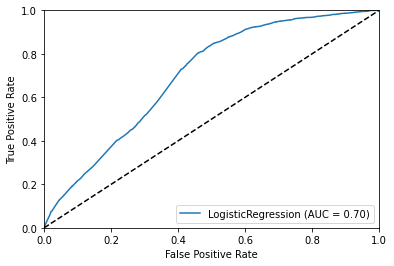

In [315]:
from sklearn.metrics import plot_roc_curve

disp = plot_roc_curve(cv['tfidf'].best_estimator_, dev, dev_labels)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])

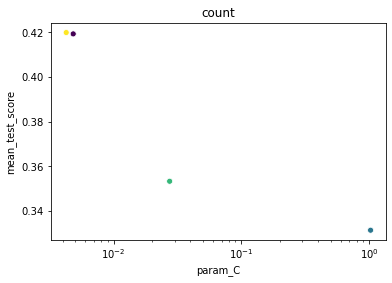

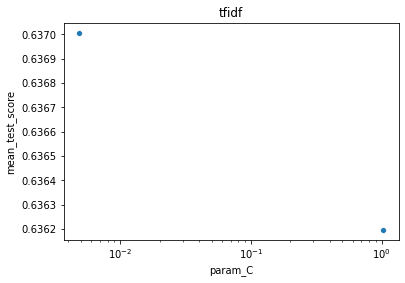

In [265]:
for k, vec in cv.items():
    results = pd.DataFrame.from_dict(vec.cv_results_)
    plt.xscale('log')
    sns.scatterplot(x='param_C', y='mean_test_score', data=results)
    plt.title(k)
    plt.show()

In [253]:
train.min(axis=0).mean(), train.mean(axis=0).mean(), train.max(axis=0).mean()

(1.031180846434486e-06, 0.00010324660782264856, 0.766175618360258)

In [254]:
from sklearn.decomposition import TruncatedSVD as PCA

pca = PCA(n_components=2, random_state=0)
train_pca = pca.fit_transform(train)
dev_pca = pca.transform(dev)

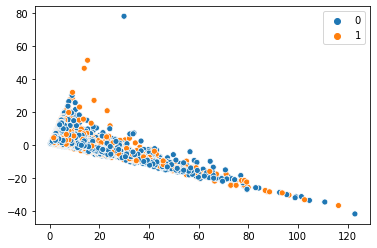

In [255]:
import seaborn as sns
%matplotlib inline

sns.scatterplot(x=train_pca[:, 0], y=train_pca[:, 1], hue=train_labels)

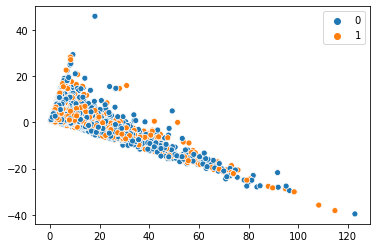

In [256]:
sns.scatterplot(x=dev_pca[:, 0], y=dev_pca[:, 1], hue=dev_labels)

In [260]:
from sklearn.linear_model import RidgeClassifier

r = RidgeClassifier(random_state=0, alpha=1)

r.fit(train_pca, train_labels)

predicted = r.predict(train_pca)

#print(f'Vectorizer: {vectorizer}')
print(f'ROC: {roc_auc_score(train_labels, predicted)}')
print(f'AP: {average_precision_score(train_labels, predicted)}')

predicted = r.predict(dev_pca)

#print(f'Vectorizer: {vectorizer}')
print(f'ROC: {roc_auc_score(dev_labels, predicted)}')
print(f'AP: {average_precision_score(dev_labels, predicted)}')

ROC: 0.5
AP: 0.333765831364499
ROC: 0.5
AP: 0.3405534829333482


In [261]:
r.coef_

array([[0.00053631, 0.00105924]])

In [262]:
pca.explained_variance_ratio_

array([0.25820159, 0.05019479])